# General Melting Point Prediction on a Diverse Compound Data Set
 > `Study of influence of molecular properties on melting points through Machine Learning models`

**_Melting point_** : The temperature at which, the solid and the liquid states of a compound are in equilibrium.

During this process, all the heat input is consumed as heat of fusion, and the temperature remains _relatively_ constant.
It can be used for estimating the purity and identity of a substance during organic synthesis and also for predicting properties like water solubility, which is mainly concerned with the _pharmaceutical industry as a prognostic measure of intestinal absorption_.

![image] (C:\Users\saiva\Desktop\Pictures of MS Project\melting point.png)



Determination of melting points is one of the oldest identification and testing methods for organic compounds, in particular. Due to the ease of measuring melting points, extensive collections of tables giving exact values of melting points for pure, organic and inorganic compounds are available. The present data set exclusively excludes inorganic compounds.

This data set is composed of 4401 compounds along with a large number of molecular descriptors to capture the physicochemical properties of compounds. Principal Component Analysis is used for dimensionality reduction, while a number of Machine Learning models have been used for model generation. 

In general, it is _challenging_ to predict melting point of compounds as it is a fundamental physicochemical property controlled by both single molecule properties and intermolecular interactions (_spatial arrangement, lattice structure, presence of electronegative atoms thereby inducing dipole interactions etc.,_). Hence, melting point models for large data sets are uncommon.

To begin with, 
## importing the required packages.......

In [80]:
import pandas as pd
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDRegressor, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from math import *
from keras.optimizers import SGD

In [81]:
#load the tsv files of the features and respective responses
df=pd.read_csv('MP_Data.tsv', sep='\t', index_col=False)
tt_df=df.rename(columns={'x':'test_train'})

In [82]:
x_df=pd.read_csv('MP_Descriptors.tsv', sep='\t', index_col=False)

In [83]:
y_df_init=pd.read_csv('MP_Outcome.tsv', sep='\t')
y_df=y_df_init.rename(columns={'x':'outcome'})
y_df.head()

,outcome
0,14.0
1,20.5
2,27.5
3,30.5
4,31.0


Sorting the giving data set of 4401 into a principal data set and external validation set, 

In [89]:
#sort the data according to external and principal datasets sets
x_dataset_init_df=x_df[tt_df['test_train']=='Train']
x_external_init_df=x_df[tt_df['test_train']=='Test']

y_dataset_init_df=y_df[tt_df['test_train']=='Train']
y_external_init_df=y_df[tt_df['test_train']=='Test']

In [90]:
x_dataset_init_df.shape, y_dataset_init_df.shape, x_external_init_df.shape, y_external_init_df.shape

((4126, 202), (4126, 1), (275, 202), (275, 1))

In [91]:
x_dataset_init_df.head()

,diameter,petitjean,petitjeanSC,radius,VDistEq,VDistMa,weinerPath,weinerPol,a_aro,a_count,...,FASA_P,FCASA.,FCASA..1,VSA,dens,glob,std_dim1,std_dim2,std_dim3,vol
0,5,0.400000,0.666667,3,2.037476,6.011166,82,9,6,15,...,0.129128,0.326050,0.224950,138.13699,0.958985,0.031032,1.853123,1.382682,0.326444,123.18750
1,9,0.444444,0.800000,5,2.954872,8.805204,1046,40,11,31,...,0.059026,0.847237,1.136764,296.30197,1.296254,0.258447,2.394159,1.966377,1.217135,262.82812
2,10,0.500000,1.000000,5,3.083532,8.211762,742,24,12,35,...,0.046707,0.817581,0.464419,296.54431,0.946322,0.162139,3.164745,1.552043,1.274330,266.62500
3,7,0.428571,0.750000,4,2.616827,7.313269,288,20,10,20,...,0.044688,0.417896,0.574827,187.43799,1.195242,0.018573,2.524826,1.446899,0.344087,164.95312
4,7,0.428571,0.750000,4,2.609669,6.833154,203,13,6,22,...,0.103925,0.595412,0.267278,193.42802,0.978233,0.088156,2.550456,1.430062,0.757260,165.79688


In [92]:
x_dataset_df=np.array(x_dataset_init_df)
x_external_df=np.array(x_external_init_df)
x_dataset_df.shape, x_external_df.shape

((4126, 202), (275, 202))

In [93]:
y_dataset_df=np.array(y_dataset_init_df)
y_external_df=np.array(y_external_init_df)

In [94]:
#normalize the output
y_scaler=StandardScaler()
y_scaler.fit(y_dataset_df)
y_train_norm=y_scaler.transform(y_dataset_df)
y_external_norm=y_scaler.transform(y_external_df)

In [95]:
#normalize the inputs
x_scaler=StandardScaler()
x_scaler.fit(x_dataset_df)
x_train_pca=x_scaler.transform(x_dataset_df)
x_external_pca=x_scaler.transform(x_external_df)

## Write about PCA

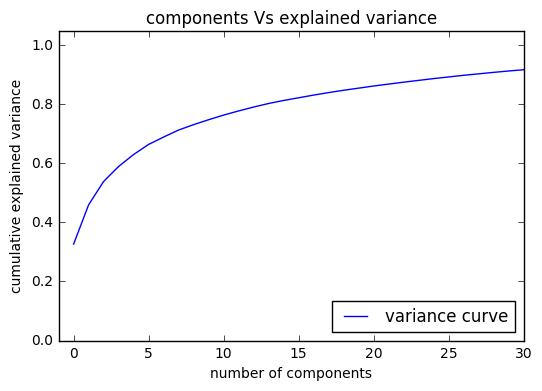

In [99]:
#feature selection
pca=PCA().fit(x_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='variance curve')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05])
plt.xlim([-1, 30])
plt.title('components Vs explained variance')
plt.show()

In [100]:
pca=PCA(n_components=30)#from the literature
pca.fit(x_train_pca)
x_train_norm=pca.transform(x_train_pca)
x_external_norm=pca.transform(x_external_pca)

x_train_norm.shape, x_external_norm.shape

((4126, 30), (275, 30))

In [98]:
pc_1=x_train_norm[:, 1]
pc_2=x_train_norm[:, 2]
pc_ex_1 = x_external_norm[:,1]
pc_ex_2 = x_external_norm[:,2]

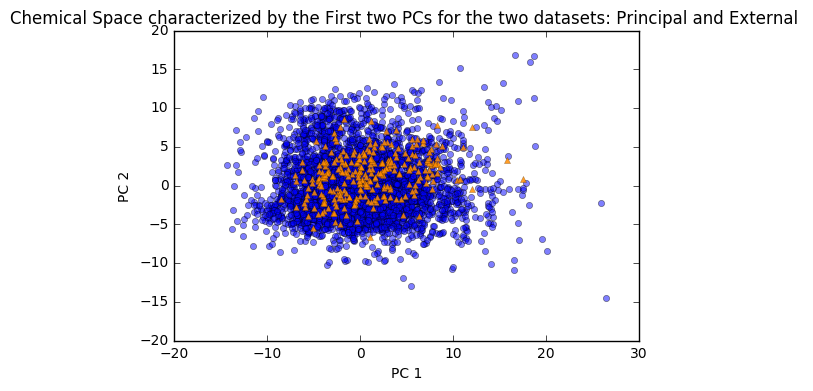

In [19]:
#Chemical space of the training and validation sets
for i in range(0, 4126):
    plt.scatter(pc_1[i], pc_2[i], c='b', alpha=0.5, marker='o', lw=0.5)
plt.hold(True)
for i in range(0, 275):    
    plt.scatter(pc_ex_1[i], pc_ex_2[i], c='darkorange', alpha=0.85, marker = '^', lw=0.15)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Chemical Space characterized by the First two PCs for the two datasets: Principal and External ')
#plt.legend(loc='lower right')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
x_training_set, x_test_set, y_training_set, y_test_set = train_test_split(x_train_norm, y_train_norm, test_size=0.2)
x_training_set.shape, x_test_set.shape, y_training_set.shape, y_test_set.shape

((3300, 30), (826, 30), (3300, 1), (826, 1))

In [21]:
#model building-linear regression
regr=linear_model.LinearRegression()
regr.fit(x_training_set, y_training_set)
y_predict_linear=regr.predict(x_test_set)

#evaluate the model

r2_linear=r2_score(y_test_set, y_predict_linear)
print('r2:',r2_linear)
mse_linear=mean_squared_error(y_test_set, y_predict_linear)
print('mse :',mse_linear)
rmse_linear=sqrt(mse_linear)
print('rmse:', rmse_linear)
mae_linear=mean_absolute_error(y_test_set, y_predict_linear)
print('mae:', mae_linear)

r2: 0.431285882856
mse : 0.574076545605
rmse: 0.7576783919346884
mae: 0.593934082158


In [22]:
#evaluate the model on the validation set
y_predict_linear_ex=regr.predict(x_external_norm)
r2_linear_ex=r2_score(y_external_norm, y_predict_linear_ex)
mse_linear_ex=mean_squared_error(y_external_norm, y_predict_linear_ex)
rmse_linear_ex=sqrt(mse_linear_ex)
mae_linear_ex=mean_absolute_error(y_external_norm, y_predict_linear_ex)

print('r2_validation_set:', r2_linear_ex)
print('rmse_validation_set:', rmse_linear_ex)
print('mse_validation_set:', mse_linear_ex)
print('mae_validation_set:', mae_linear_ex)

r2_validation_set: 0.184159054538
rmse_validation_set: 0.769152775743889
mse_validation_set: 0.591595992435
mae_validation_set: 0.60158299527


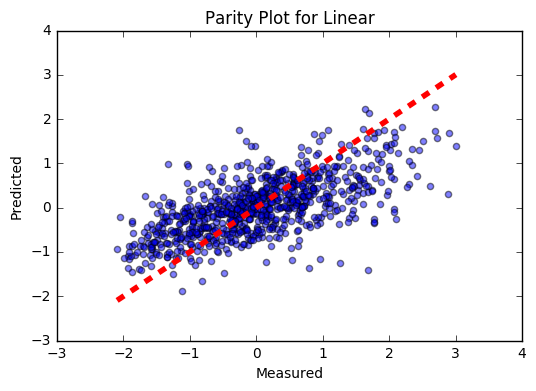

In [23]:
#parity plot for linear regression
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_linear, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()],'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Linear')
plt.show()

In [24]:
regr.score(x_training_set, y_training_set)

0.43416398619443264

In [25]:
#Lasso
regr_lasso=linear_model.Lasso(alpha=0.01)
regr_lasso.fit(x_training_set, y_training_set)
y_predict_lasso=regr_lasso.predict(x_test_set)

#evaluate

mse_lasso=mean_squared_error(y_test_set, y_predict_lasso)
rmse_lasso=sqrt(mse_lasso)
mae_lasso=mean_absolute_error(y_test_set, y_predict_lasso)
r2_lasso=r2_score(y_test_set, y_predict_lasso)
print('r2 for lasso:',r2_lasso)
print('rmse for lasso', rmse_lasso)
print('mae for lasso', mae_lasso)

r2 for lasso: 0.430319437224
rmse for lasso 0.7583218999159208
mae for lasso 0.595511066686


In [26]:
#evaluate the model on validation set

y_predict_lasso_ex=regr_lasso.predict(x_external_norm)
r2_lasso_ex=r2_score(y_external_norm, y_predict_lasso_ex)
mse_lasso_ex=mean_squared_error(y_external_norm, y_predict_lasso_ex)
rmse_lasso_ex=sqrt(mse_lasso_ex)
mae_lasso_ex=mean_absolute_error(y_external_norm, y_predict_lasso_ex)

print('r2_validation_set:', r2_lasso_ex)
print('rmse_validation_set:', rmse_lasso_ex)
print('mse_validation_set:', mse_lasso_ex)
print('mae_validation_set:', mae_lasso_ex)

r2_validation_set: 0.212264274564
rmse_validation_set: 0.7557882464413761
mse_validation_set: 0.571215873459
mae_validation_set: 0.594773816661


In [27]:
print(regr_lasso.coef_)

[ 0.03115202  0.02654631 -0.05324807  0.04105858  0.02218641 -0.05853763
 -0.0215131   0.14499237 -0.         -0.08009161  0.04310588 -0.00020546
 -0.12090866  0.07072228 -0.03855514 -0.03231896  0.          0.05205522
 -0.06899462  0.01815877 -0.06737409  0.05273411 -0.04785372  0.
 -0.05598656 -0.03091649  0.          0.05139587  0.06543167 -0.08391003]


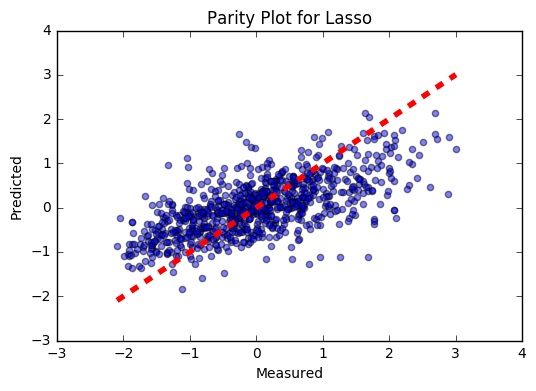

In [28]:
#parity plot for lasso
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_lasso, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Lasso')
plt.show()

In [29]:
regr_lasso.score(x_training_set, y_training_set)

0.4328046924711807

In [30]:
#LassoCV
model_CV=LassoCV(cv=20).fit(x_training_set, y_training_set)
y_predict_CV = model_CV.predict(x_test_set)

#evaluate

mse_lassoCV=mean_squared_error(y_test_set, y_predict_CV)
rmse_lassoCV=sqrt(mse_lassoCV)
r2_lassoCV=r2_score(y_test_set, y_predict_CV)
mae_lassoCV=mean_absolute_error(y_test_set, y_predict_CV)

print('r2 for lassoCV:',r2_lassoCV)
print('rmse for lassoCV',rmse_lassoCV )
print('mae for lassoCV', mae_lassoCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for lassoCV: 0.430875322036
rmse for lassoCV 0.7579518306723284
mae for lassoCV 0.59469908646


In [31]:
print(model_CV.coef_)

[ 0.03119242  0.02671505 -0.05349873  0.04144223  0.02262778 -0.05901626
 -0.02231018  0.14582151 -0.         -0.08109184  0.04424609 -0.00157469
 -0.12216385  0.07218624 -0.04020101 -0.03428067  0.00042835  0.05436626
 -0.07126096  0.02067079 -0.07028292  0.05544927 -0.05115185 -0.
 -0.05922265 -0.03450517  0.00033851  0.05534588  0.06941123 -0.08808388]


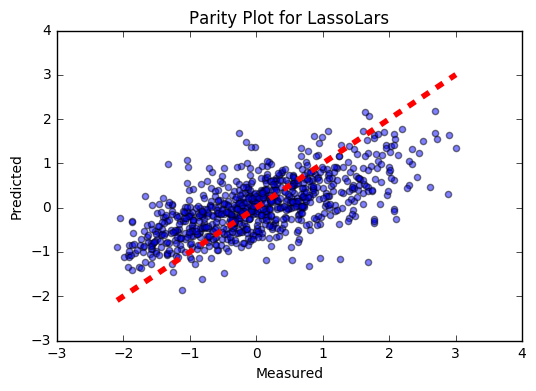

In [32]:
#parity plot for cross validated lasso
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_CV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLars')
plt.show()

In [33]:
#LassoLarsCV
model_larsCV=LassoLarsCV(cv=20).fit(x_training_set, y_training_set)
y_predict_larsCV=model_larsCV.predict(x_test_set)

#evaluate
r2_larsCV=r2_score(y_test_set, y_predict_larsCV)
mse_larsCV=mean_squared_error(y_test_set, y_predict_larsCV)
rmse_larsCV=sqrt(mse_larsCV)
mae_larsCV=mean_absolute_error(y_test_set, y_predict_larsCV)
print('rmse for lassCV:', rmse_larsCV)
print('r2 for lasso larsCV:',r2_larsCV)
print('mae for larsCV:', mae_larsCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse for lassCV: 0.7583068054852841
r2 for lasso larsCV: 0.430342116031
mae for larsCV: 0.595273225734


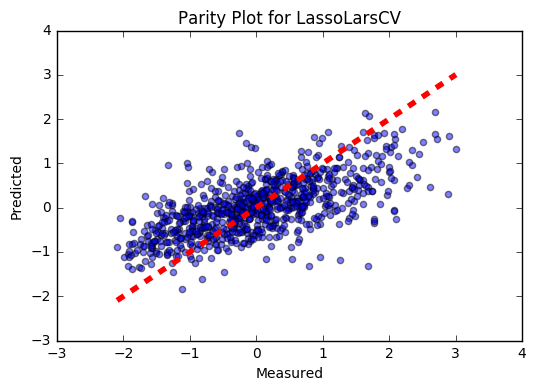

In [34]:
#parity plot for least angle regression lasso
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_larsCV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLarsCV')
plt.show()

In [35]:
#Bayesian Ridge
regr_b=linear_model.BayesianRidge()
model_b=regr_b.fit(x_training_set, y_training_set)
y_predict_b=model_b.predict(x_test_set)

#evaluate

mse_b=mean_squared_error(y_test_set, y_predict_b)
rmse_b=sqrt(mse_b)
mae_b=mean_absolute_error(y_test_set, y_predict_b)
r2_b=r2_score(y_test_set, y_predict_b)
print('r2 for bayesian in true space:',r2_b)
print('rmse for bayesian in true space:', rmse_b)
print('mae for bayesian in true space:', mae_b)

r2 for bayesian in true space: 0.431359652355
rmse for bayesian in true space: 0.7576292500490888
mae for bayesian in true space: 0.594542357084


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


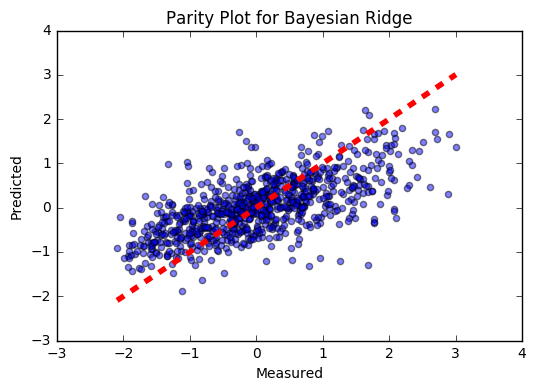

In [36]:
#parity plot for bayesian ridge
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_b, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Bayesian Ridge')
plt.show()

In [37]:
#stochastic gradient descent
regr_sgd=SGDRegressor(loss='squared_loss', penalty=None, alpha=0.001, epsilon=0.0001)
model_sgd=regr_sgd.fit(x_training_set, y_training_set)
y_predict_sgd=model_sgd.predict(x_test_set)

#evaluate

mse_sgd=mean_squared_error(y_test_set, y_predict_sgd)
rmse_sgd=sqrt(mse_sgd)
mae_sgd=mean_absolute_error(y_test_set, y_predict_sgd)
r2_sgd=r2_score(y_test_set, y_predict_sgd)

print('r2 for sgd in true space:',r2_sgd)
print('rmse for sgd in true space:', rmse_sgd)
print('mae for sgd in true space:', mae_sgd)

r2 for sgd in true space: 0.374539111073
rmse for sgd in true space: 0.7945806346741573
mae for sgd in true space: 0.621410809165


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
#evaluate model on the external validation set
y_predict_sgd_ex=regr_sgd.predict(x_external_norm)
r2_sgd_ex=r2_score(y_external_norm, y_predict_sgd_ex)
mse_sgd_ex=mean_squared_error(y_external_norm, y_predict_sgd_ex)
rmse_sgd_ex=sqrt(mse_sgd_ex)
mae_sgd_ex=mean_absolute_error(y_external_norm, y_predict_sgd_ex)

print('r2_validation_set:', r2_sgd_ex)
print('rmse_validation_set:', rmse_sgd_ex)
print('mse_validation_set:', mse_sgd_ex)
print('mae_validation_set:', mae_sgd_ex)

r2_validation_set: 0.332236620436
rmse_validation_set: 0.6958588611281479
mse_validation_set: 0.484219554611
mae_validation_set: 0.556753551501


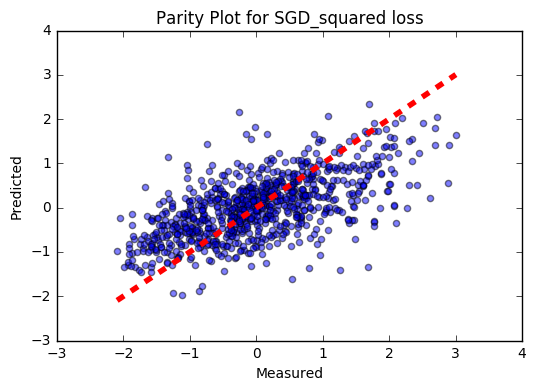

In [39]:
#parity plot for Stochastic Gradient Descent
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SGD_squared loss')
plt.show()

In [40]:
regr_sgd2=linear_model.SGDRegressor(loss='huber', penalty=None)
model_sgd2=regr_sgd2.fit(x_training_set, y_training_set)
y_predict_sgd2=model_sgd2.predict(x_test_set)

#evaluate

mse_sgd2=mean_squared_error(y_test_set, y_predict_sgd2)
rmse_sgd2=sqrt(mse_sgd2)
mae_sgd2=mean_absolute_error(y_test_set, y_predict_sgd2)
r2_sgd2=r2_score(y_test_set, y_predict_sgd2)

print('r2 for sgd2 in true space:',r2_sgd2)
print('rmse for sgd2 in true space:', rmse_sgd2)
print('mae for sgd2 in true space:', mae_sgd2)

r2 for sgd2 in true space: 0.400840399983
rmse for sgd2 in true space: 0.7776947345647202
mae for sgd2 in true space: 0.599420106831


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
#evaluate sgd on external validation set
y_predict_sgd2_ex=regr_sgd2.predict(x_external_norm)
r2_sgd2_ex=r2_score(y_external_norm, y_predict_sgd2_ex)
mse_sgd2_ex=mean_squared_error(y_external_norm, y_predict_sgd2_ex)
rmse_sgd2_ex=sqrt(mse_sgd2_ex)
mae_sgd2_ex=mean_absolute_error(y_external_norm, y_predict_sgd2_ex)

print('r2_validation_set:', r2_sgd2_ex)
print('rmse_validation_set:', rmse_sgd2_ex)
print('mse_validation_set:', mse_sgd2_ex)
print('mae_validation_set:', mae_sgd2_ex)

r2_validation_set: 0.19725443511
rmse_validation_set: 0.7629548183796601
mse_validation_set: 0.582100054889
mae_validation_set: 0.59520955657


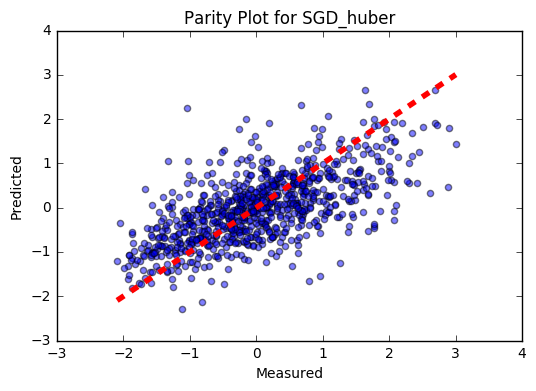

In [42]:
#parity plot for sgd_huber
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd2, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SGD_huber')
plt.show()

In [43]:
regr_sgd3=linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='none', alpha=0.0001)
model_sgd3=regr_sgd3.fit(x_training_set, y_training_set)
y_predict_sgd3=model_sgd3.predict(x_test_set)

#evaluate

mse_sgd3=mean_squared_error(y_test_set, y_predict_sgd3)
rmse_sgd3=sqrt(mse_sgd3)
mae_sgd3=mean_absolute_error(y_test_set, y_predict_sgd3)
r2_sgd3=r2_score(y_test_set, y_predict_sgd3)

print('r2 for sgd3 in true space:',r2_sgd3)
print('rmse for sgd3 in true space:', rmse_sgd3)
print('mae for sgd3 in true space:', mae_sgd3)

r2 for sgd3 in true space: 0.349295788054
rmse for sgd3 in true space: 0.8104564937946562
mae for sgd3 in true space: 0.627576829572


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


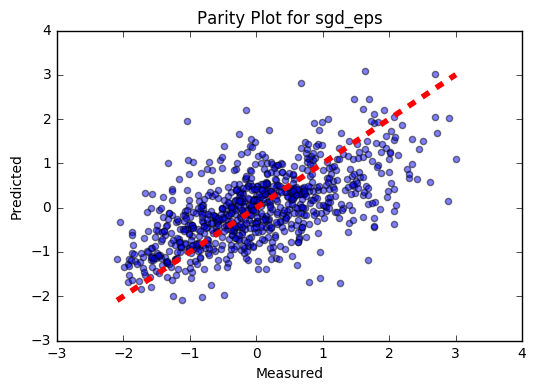

In [44]:
#parity plot for sgd_epsilon insensitive loss function
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd3, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for sgd_eps')
plt.show()

In [45]:
#using tree
regr_tree=tree.DecisionTreeRegressor()
model_tree=regr_tree.fit(x_training_set, y_training_set)
y_predict_tree=model_tree.predict(x_test_set)

#evaluate

mse_tree=mean_squared_error(y_test_set, y_predict_tree)
rmse_tree=sqrt(mse_tree)
mae_tree=mean_absolute_error(y_test_set, y_predict_tree)
r2_tree=r2_score(y_test_set, y_predict_tree)
print('r2 for tree in true space:',r2_tree)
print('rmse for tree in true space:', rmse_tree)
print('mae for tree in true space:', mae_tree)

r2 for tree in true space: -0.0262621269714
rmse for tree in true space: 1.017810785048605
mae for tree in true space: 0.792410208883


In [46]:
#evaluating CART on external validation set
y_predict_tree_ex=regr_tree.predict(x_external_norm)
r2_tree_ex=r2_score(y_external_norm, y_predict_tree_ex)
mse_tree_ex=mean_squared_error(y_external_norm, y_predict_tree_ex)
rmse_tree_ex=sqrt(mse_tree_ex)
mae_tree_ex=mean_absolute_error(y_external_norm, y_predict_tree_ex)

print('r2_validation_set:', r2_tree_ex)
print('rmse_validation_set:', rmse_tree_ex)
print('mse_validation_set:', mse_tree_ex)
print('mae_validation_set:', mae_tree_ex)

r2_validation_set: -1.5815345116
rmse_validation_set: 1.3681976192566017
mse_validation_set: 1.87196472534
mae_validation_set: 1.03959179053


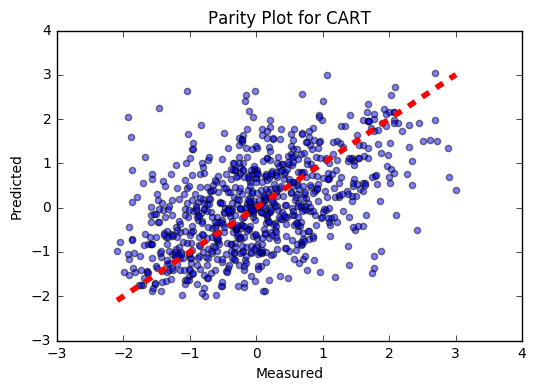

In [47]:
#parity plot for CART 
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_tree, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for CART')
plt.show()

In [48]:
#Ridge
regr_ridge=linear_model.Ridge(alpha=0.75)
model_ridge=regr_ridge.fit(x_training_set, y_training_set)
y_predict_ridge=model_ridge.predict(x_test_set)

#evaluate

mse_ridge=mean_squared_error(y_test_set, y_predict_ridge)
rmse_ridge=sqrt(mse_ridge)
mae_ridge=mean_absolute_error(y_test_set, y_predict_ridge)
r2_ridge=r2_score(y_test_set, y_predict_ridge)
print('r2 for ridge in true space:',r2_ridge)
print('rmse for ridge in true space:', rmse_ridge)
print('mae for ridge in true space:', mae_ridge)

r2 for ridge in true space: 0.431286998668
rmse for ridge in true space: 0.7576776486549439
mae for ridge in true space: 0.593936922246


In [49]:
#evaluate the model on external validation set
y_predict_ridge_ex=regr_ridge.predict(x_external_norm)
r2_ridge_ex=r2_score(y_external_norm, y_predict_ridge_ex)
mse_ridge_ex=mean_squared_error(y_external_norm, y_predict_ridge_ex)
rmse_ridge_ex=sqrt(mse_ridge_ex)
mae_ridge_ex=mean_absolute_error(y_external_norm, y_predict_ridge_ex)

print('r2_validation_set:', r2_ridge_ex)
print('rmse_validation_set:', rmse_ridge_ex)
print('mse_validation_set:', mse_ridge_ex)
print('mae_validation_set:', mae_ridge_ex)

r2_validation_set: 0.18430525852
rmse_validation_set: 0.7690838540763073
mse_validation_set: 0.591489974601
mae_validation_set: 0.601537725634


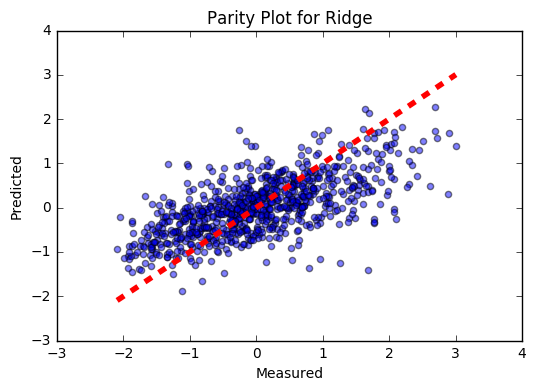

In [50]:
#parity plot for Ridge
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_ridge, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Ridge')
plt.show()

In [51]:
#Kernel Ridge
regr_kr=KernelRidge(alpha=1.0)
model_kr=regr_kr.fit(x_training_set, y_training_set)
y_predict_kr=model_kr.predict(x_test_set)

#evaluate

mse_kr=mean_squared_error(y_test_set, y_predict_kr)
rmse_kr=sqrt(mse_kr)
mae_kr=mean_absolute_error(y_test_set, y_predict_kr)
r2_kr=r2_score(y_test_set, y_predict_kr)
print('r2 for kernel ridge in true space:',r2_kr)
print('rmse for kernel ridge in true space:', rmse_kr)
print('mae for kernel ridge in true space:', mae_kr)

r2 for kernel ridge in true space: 0.431288116756
rmse for kernel ridge in true space: 0.7576769038587401
mae for kernel ridge in true space: 0.593907447285


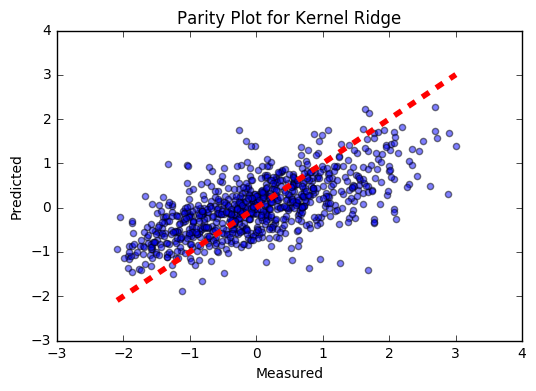

In [52]:
#parity plot for kernal ridge
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_kr, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Kernel Ridge')
plt.show()

In [53]:
#support vector machines
svr_rbf=SVR(kernel='rbf', C=1e3)
model_rbf=svr_rbf.fit(x_training_set, y_training_set)
y_predict_rbf=model_rbf.predict(x_test_set)

#evaluate

mse_rbf=mean_squared_error(y_test_set, y_predict_rbf)
rmse_rbf=sqrt(mse_rbf)
mae_rbf=mean_absolute_error(y_test_set, y_predict_rbf)
r2_rbf=r2_score(y_test_set, y_predict_rbf)
print('r2 for svm.rbf in true space:',r2_rbf)
print('rmse for svm.rbf in true space:', rmse_rbf)
print('mae for svm.rbf in true space:', mae_rbf)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.rbf in true space: 0.421601557903
rmse for svm.rbf in true space: 0.7641022081174776
mae for svm.rbf in true space: 0.589436531824


In [54]:
#evaluate the model on external validation set
y_predict_svr_rbf_ex=svr_rbf.predict(x_external_norm)
r2_svr_rbf_ex=r2_score(y_external_norm, y_predict_svr_rbf_ex)
mse_svr_rbf_ex=mean_squared_error(y_external_norm, y_predict_svr_rbf_ex)
rmse_svr_rbf_ex=sqrt(mse_svr_rbf_ex)
mae_svr_rbf_ex=mean_absolute_error(y_external_norm, y_predict_svr_rbf_ex)

print('r2_validation_set:', r2_svr_rbf_ex)
print('rmse_validation_set:', rmse_svr_rbf_ex)
print('mse_validation_set:', mse_svr_rbf_ex)
print('mae_validation_set:', mae_svr_rbf_ex)

r2_validation_set: -0.132337324463
rmse_validation_set: 0.9061451580775979
mse_validation_set: 0.821099047507
mae_validation_set: 0.737739251285


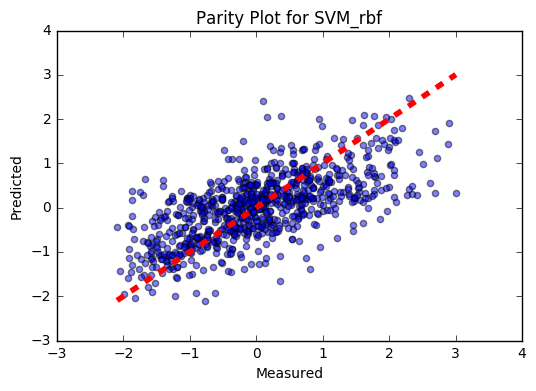

In [55]:
#parity plot for SVM_rbf
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_rbf, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SVM_rbf')
plt.show()

In [56]:
svr_sig=SVR(kernel='sigmoid', C=1e3)
model_sig=svr_sig.fit(x_training_set, y_training_set)
y_predict_sig=model_sig.predict(x_test_set)

#evaluate

mse_sig=mean_squared_error(y_test_set, y_predict_sig)
rmse_sig=sqrt(mse_sig)
mae_sig=mean_absolute_error(y_test_set, y_predict_sig)
r2_sig=r2_score(y_test_set, y_predict_sig)

print('r2 for svm.sig in true space:',r2_sig)
print('rmse for svm.sig in true space:', rmse_sig)
print('mae for svm.sig in true space:', mae_sig)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.sig in true space: -55408014733.4
rmse for svm.sig in true space: 236496.21381970868
mae for svm.sig in true space: 191150.455988


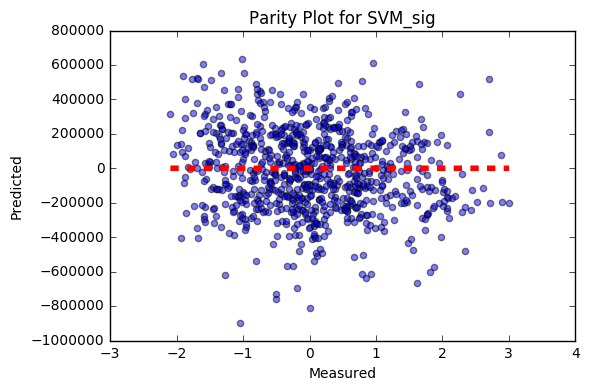

In [57]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sig, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SVM_sig')
plt.show()

In [58]:
#C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf, rmse_rbf])
#C

In [59]:
C=np.array([r2_linear, r2_lasso, r2_lassoCV, r2_larsCV, r2_b, r2_sgd, r2_sgd2, r2_sgd3, r2_tree, r2_ridge, r2_kr, r2_rbf])
C

array([ 0.43128588,  0.43031944,  0.43087532,  0.43034212,  0.43135965,
        0.37453911,  0.4008404 ,  0.34929579, -0.02626213,  0.431287  ,
        0.43128812,  0.42160156])

In [60]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

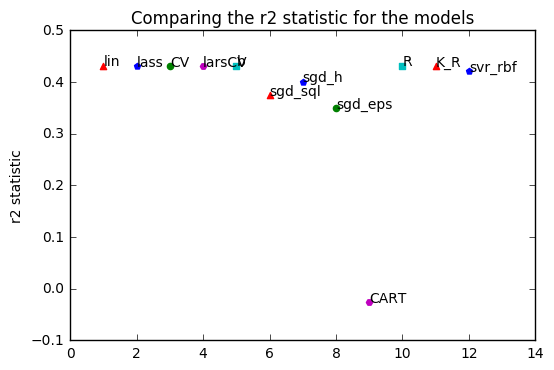

In [61]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('r2 statistic')
plt.title('Comparing the r2 statistic for the models')
plt.show()

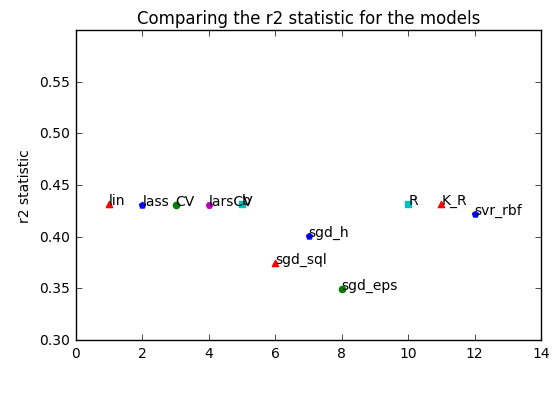

In [62]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('r2 statistic')
plt.ylim([0.30, 0.6])
plt.title('Comparing the r2 statistic for the models')
plt.show()

In [63]:
C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf])
C

array([ 0.75767839,  0.7583219 ,  0.75795183,  0.75830681,  0.75762925,
        0.79458063,  0.77769473,  0.81045649,  1.01781079,  0.75767765,
        0.7576769 ,  0.76410221])

In [64]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

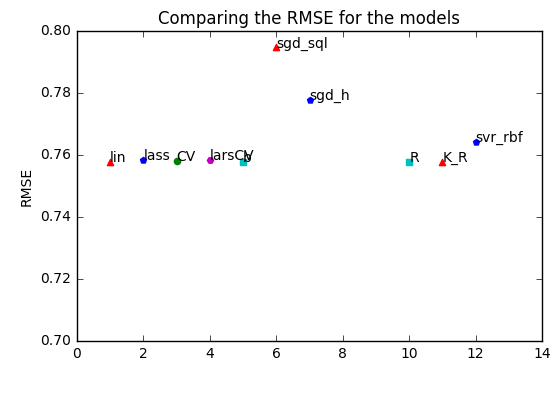

In [65]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('RMSE')
plt.ylim([0.70, 0.80])
plt.title('Comparing the RMSE for the models')
plt.show()

In [66]:
C=np.array([mae_linear, mae_lasso, mae_lassoCV, mae_larsCV, mae_b, mae_sgd, mae_sgd2, mae_sgd3, mae_tree, mae_ridge, mae_kr, mae_rbf])
C

array([ 0.59393408,  0.59551107,  0.59469909,  0.59527323,  0.59454236,
        0.62141081,  0.59942011,  0.62757683,  0.79241021,  0.59393692,
        0.59390745,  0.58943653])

In [67]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

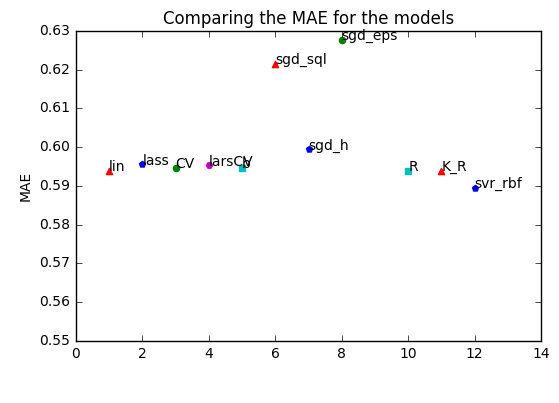

In [68]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('MAE')
plt.ylim([0.55, 0.63])
plt.title('Comparing the MAE for the models')
plt.show()

**NEURAL NETWORK**

In [101]:
#DIFFERENT TOPOLOGIES HAVE BEEN GIVEN TO 2D , 3D AND 2D/3D DESCRIPTORS AND ITERATIONS OF CONJUGATED GRADIENT DESCENT GIVEN
def baseline_model():
    model=Sequential()
    #model.add(Dropout(0.2, input_shape=(30,)))
    model.add(Dense(27, init='normal', input_dim=30, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(20, init='normal', activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(18, init='normal', activation='relu'))
    #model.add(Dropout(0,2))
    #model.add(Dense(12, init='normal', activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(6, init='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(5, init='normal', activation='relu'))
    ##model.add(Dropout(0.2))
    model.add(Dense(1, init='normal'))
    # compile the model 
    epochs=100
    learning_rate=0.01
    momemtum=0.3
    decay=learning_rate/epochs
    sgd=SGD(lr=learning_rate, momentum=momemtum, decay=decay, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [102]:
seed=7
#fit and evaluate the NN
estimators=[]
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=50, batch_size=5, verbose=0)))
pipeline=Pipeline(estimators)
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
results=cross_val_score(pipeline, x_training_set, y_training_set, cv=kfold, scoring='r2')
results.mean(), results.std()

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(27, activation="relu", input_dim=30, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(27, activation="relu", input_dim=30, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__

(0.49320325157981165, 0.057651931615397126)

In [103]:
results_test=cross_val_score(pipeline, x_test_set, y_test_set, cv=kfold, scoring='r2')
results_test.mean(), results_test.std()

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(27, activation="relu", input_dim=30, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(27, activation="relu", input_dim=30, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__

(0.38866844454134142, 0.096798850986555496)

**TENSORFLOW MODEL**

In [ ]:
import tensorflow as tf

In [ ]:
COLUMNS=list(x_df)
len(COLUMNS)